In [194]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
data = pd.read_csv('Taxi.4.csv', index_col=0, parse_dates=True)

## В качестве метрики расстояния между временными рядами используем DTW. Данная метрика позволяет находить похожие по форме временные ряды

In [197]:
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

In [198]:
def dtw(a,b):
    dist, path= fastdtw(a,b, dist=euclidean)
    return dist

## Загрузили данные за 2016 год по июнь включительно

In [199]:
from scipy.cluster import hierarchy

### Для кластеризации используем данные за два месяца

#### Не забываем про нормализацию!

In [200]:
data_cl=pd.DataFrame(StandardScaler().fit_transform(data.loc['2016-03-01':'2016-04-30']),
                                                   columns=data.columns,
                                                   index=data.loc['2016-03-01':'2016-04-30'].index)

### Поскольку возникает проблема выбросов, используем алгоритм LOF для предварительной очистки каждого ряда

#### Для того, чтобы исключить локальные выбросы - будем искать аутлаеры по ряду из которого вычтено его скользящее среднее за пару дней:

In [201]:
lof=LocalOutlierFactor(n_neighbors=100, contamination=0.1, n_jobs=-1)

In [202]:
for i in data_cl.columns:
    data_cl[i]=data_cl[i][(lof.fit_predict(data_cl[[i]]-data_cl[[i]].rolling('2d').mean())==1)]

In [203]:
data_cl=data_cl.interpolate(limit=5)
data_cl.dropna(inplace=True)

### Кластеризуем

In [204]:
%%time
Z = hierarchy.linkage(data_cl.T, 'complete', metric=dtw)

CPU times: user 25min 45s, sys: 4.31 s, total: 25min 49s
Wall time: 25min 43s


In [248]:
Z=pd.read_csv('hir.csv', index_col=0).values

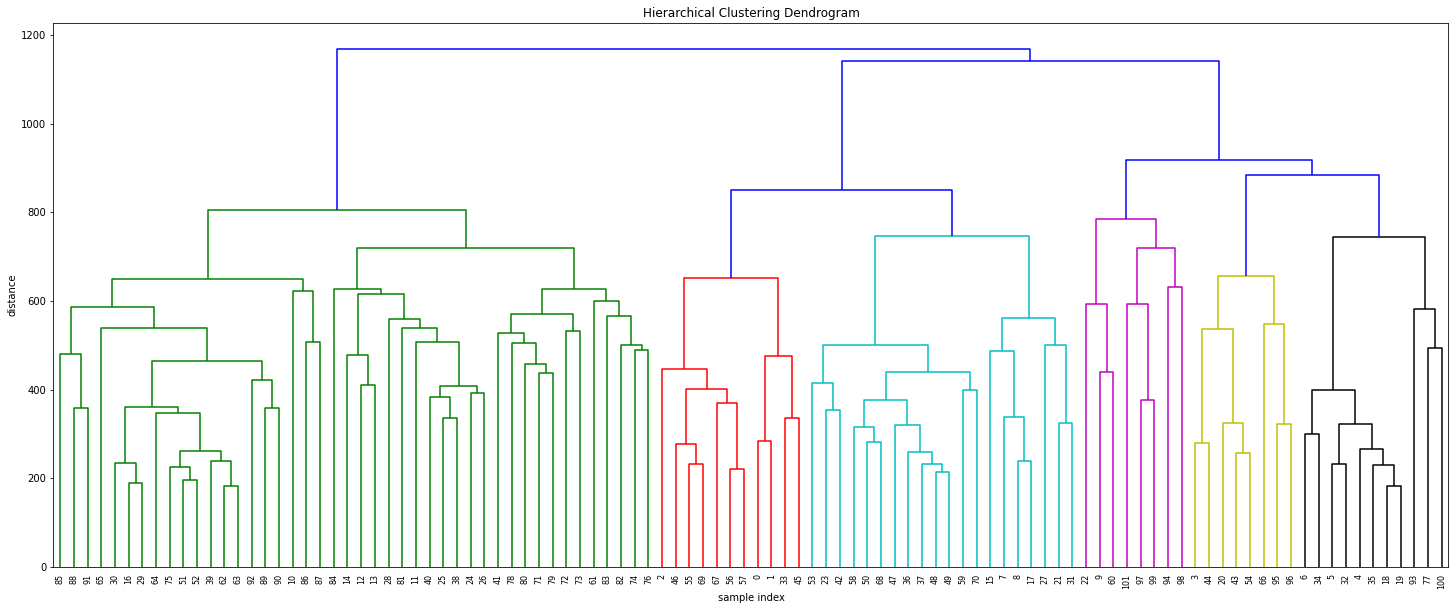

In [249]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Выделим 3 крупных кластеров

In [250]:
a=hierarchy.fcluster(Z, t=3, criterion='maxclust')
for i in np.unique(a):
    print(f'Кластер:{i}, количество рядов в кластере:{np.sum(a==i)}')

Кластер:1, количество рядов в кластере:44
Кластер:2, количество рядов в кластере:31
Кластер:3, количество рядов в кластере:27


### Сохраним результаты кластеризации

In [251]:
w=pd.Series(a, index=data.columns, name='cluster')

In [252]:
w.to_csv('3clusters.csv')

### Проверим похожесть на очищенных данных за апрель

#### номер 1

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

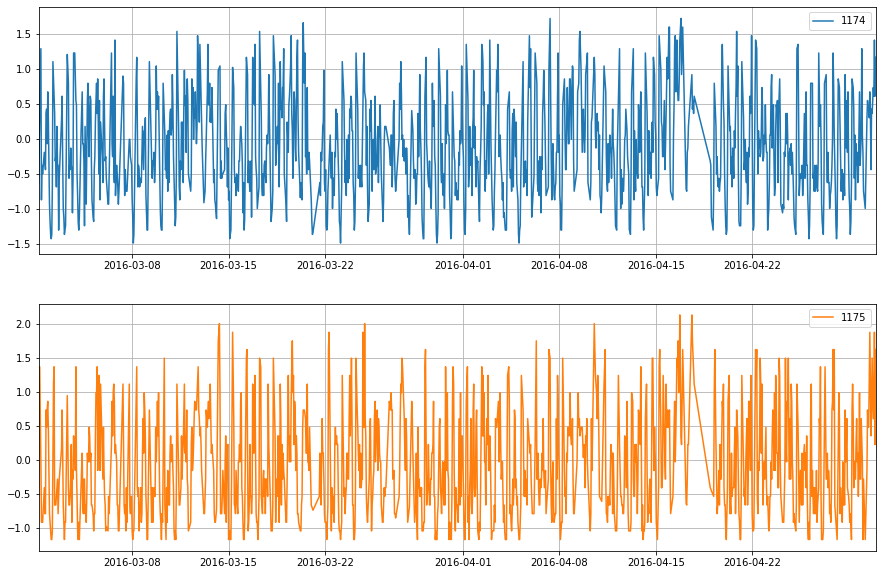

In [254]:
data_cl.loc[:,w[(w==1)].index.values[3:5]].plot(subplots=True, figsize=(15,10), sharex=False, grid=True)

#### номер 2

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

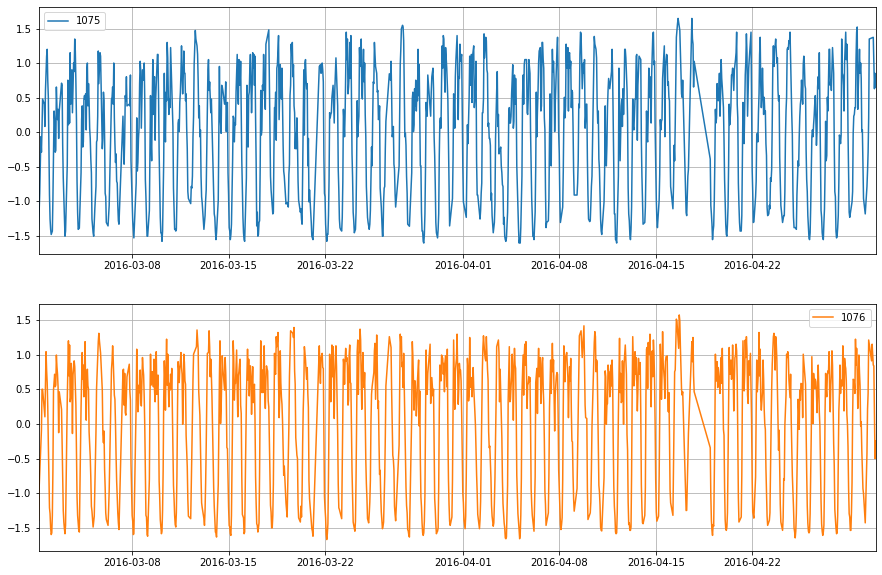

In [255]:
data_cl.loc[:,w[(w==2)].index.values[:2]].plot(subplots=True, figsize=(15,10), sharex=False, grid=True)

#### номер 3

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

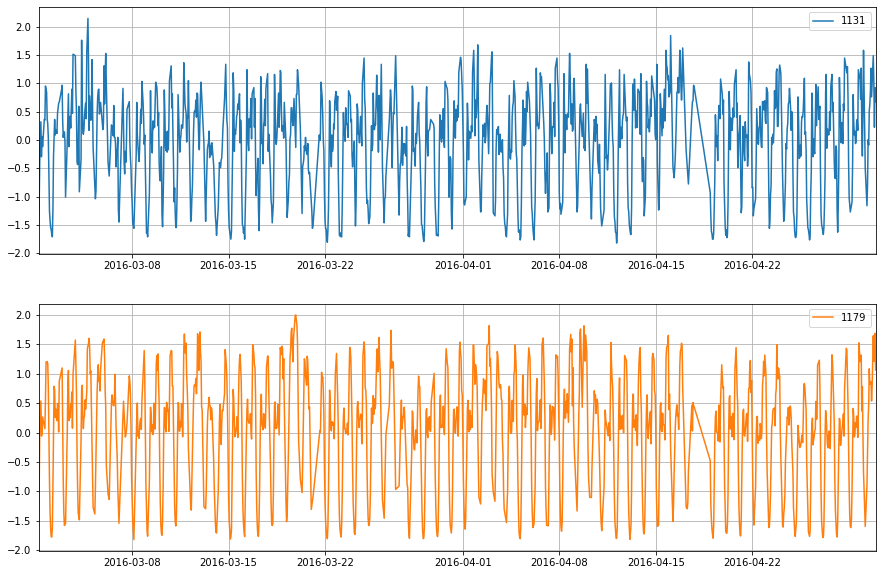

In [256]:
data_cl.loc[:,w[(w==3)].index.values[4:6]].plot(subplots=True, figsize=(15,10), sharex=False, grid=True)

#### Все смотреть не будем. Получилось действительно похоже

## Начнем строить модели для  каждого кластера

#### Главные серии кластеров:

Т.е. те, сумма расстояний от которых до всех остальных серий, входящих в кластер, минимальна.
В качестве метрики расстояния используем DTW

In [257]:
%%time
T=pd.DataFrame(columns=np.unique(a), index=['Series'])
for cl in np.unique(a):
    r=pd.DataFrame(0, columns=data_cl.loc[:,w[(w==cl)].index.values].columns, index=['sum'])
    for i in r.columns:
        for j in r.drop(columns=[i]).columns:
            r[i]+=dtw(data_cl[i], data_cl[j])
    T[cl]=r[r==r.min(axis=1)[0]].dropna(how='all', axis=1).columns[0]

CPU times: user 17min 3s, sys: 2.91 s, total: 17min 6s
Wall time: 17min 2s


In [258]:
T

,1,2,3
Series,1227,1235,1179


## Обучение моделей

In [259]:
train_data=data.loc[:'2016-04-30'][['1227', '1235', '1179']]

In [260]:
train_data.columns=['y1', 'y2', 'y3']

#### Проверим отсутствие тренда в данных

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

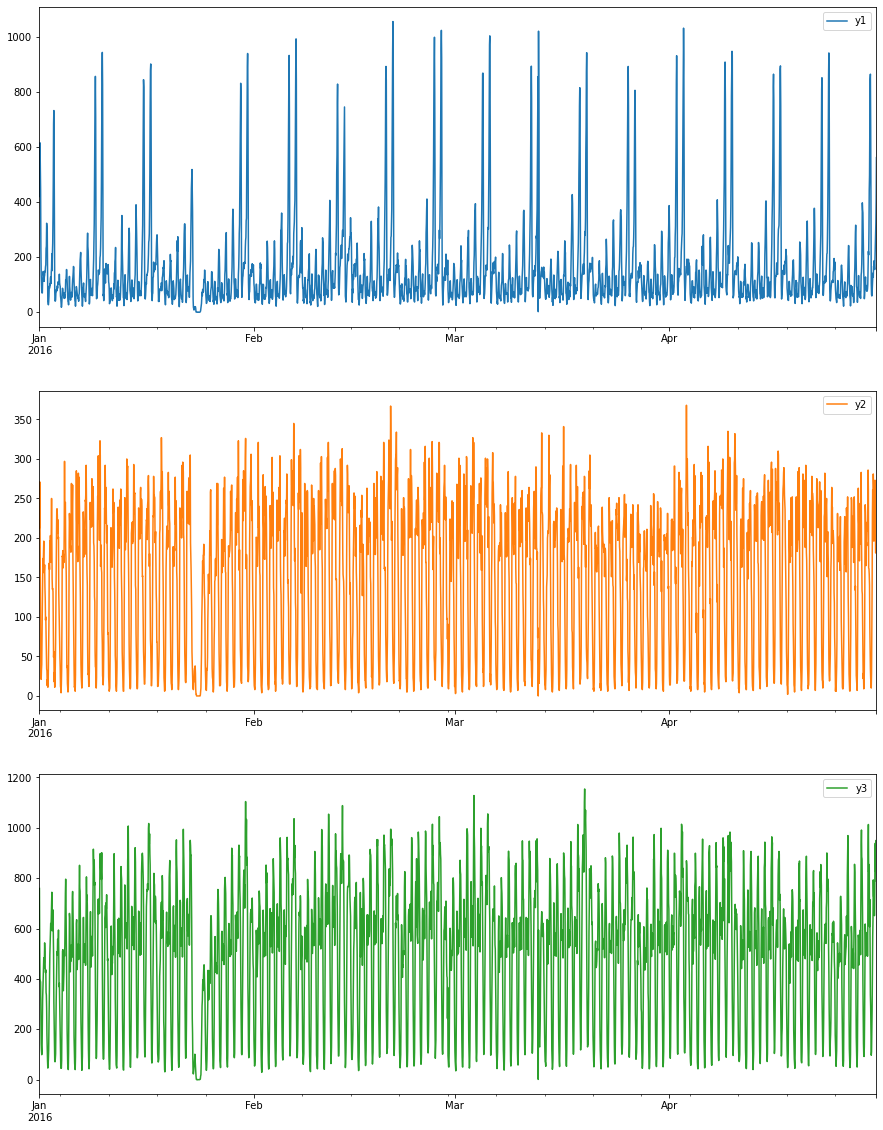

In [261]:
train_data[['y1', 'y2', 'y3']].plot(figsize=(15,20), subplots=True, sharex=False)

### Недельная сезонность

In [262]:
for i in range(1, 6):
    train_data[f'w_s{i}']=np.sin(np.arange(1, train_data.shape[0]+1, 1)*2*np.pi*i/168)
    train_data[f'w_c{i}']=np.cos(np.arange(1, train_data.shape[0]+1, 1)*2*np.pi*i/168)

### Посмотрим на df:

In [263]:
train_data.head()

,y1,y2,y3,w_s1,w_c1,w_s2,w_c2,w_s3,w_c3,w_s4,w_c4,w_s5,w_c5
2016-01-01 00:00:00,420,213,759,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566
2016-01-01 01:00:00,613,271,518,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874
2016-01-01 02:00:00,615,214,401,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724
2016-01-01 03:00:00,542,152,391,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052
2016-01-01 04:00:00,444,62,388,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820


## Построим регрессию

In [264]:
import statsmodels.formula.api as smf
import scipy as sc
import statsmodels.api as sm

Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.000000
Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.000000
Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.000001


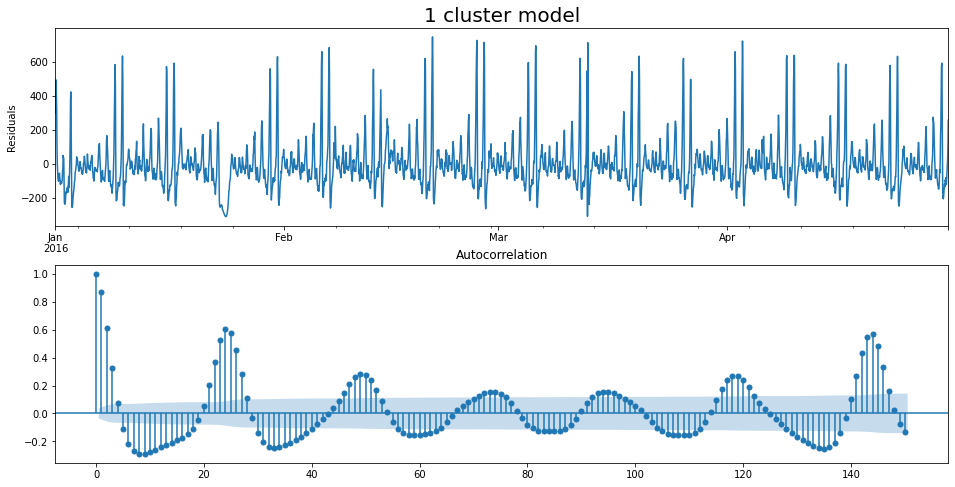

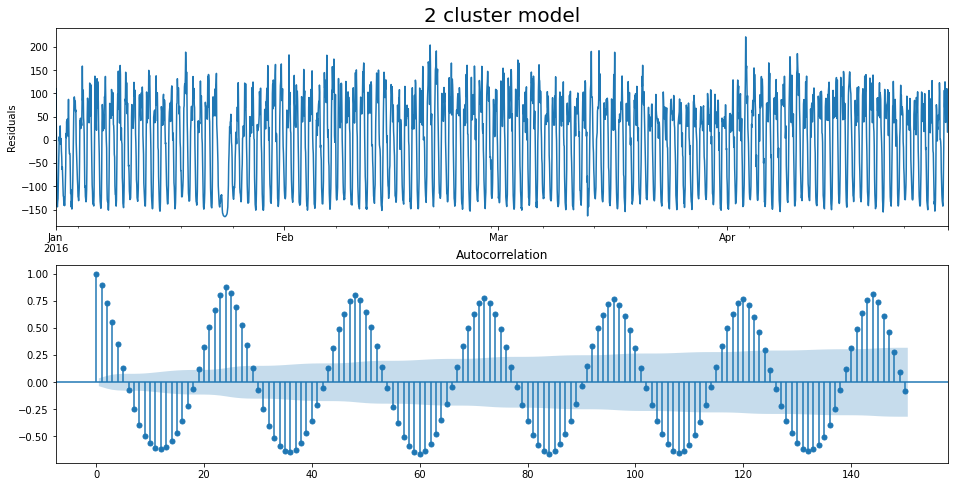

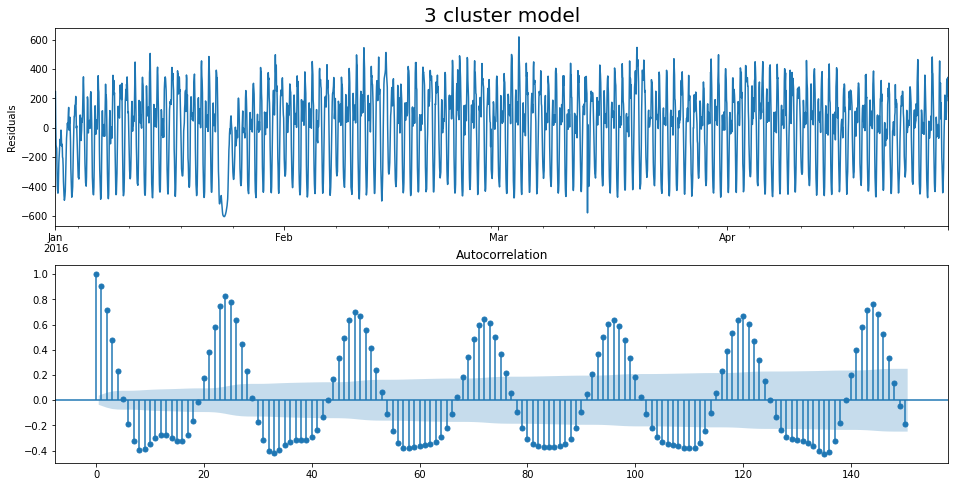

In [265]:
for n, i in enumerate(train_data.columns[:3]):
    m2 = smf.ols(f'{i} ~ w_s1 + w_c1 + w_s2 + w_c2 + w_s3 + w_c3 + w_s4 + w_c4+'\
           'w_s5 + w_c5', data=train_data)
    fitted = m2.fit()

    plt.figure(figsize=(16,8))
    plt.subplot(211)
    plt.title(f'{n+1} cluster model', fontsize=20)
    fitted.resid.plot()
    plt.ylabel(u'Residuals')

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(fitted.resid.values.squeeze(), lags=150, ax=ax)

    print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(fitted.resid, 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(fitted.resid)[1])
    
    train_data[f'resid_{i}']=fitted.resid

#### Остатки несмещены, ряды остатков стационарны, однако наблюдается высокая автокорреляция. Возможно она обусловлена суточной сезонностью, переходим к моделированию остатков моделью ARIMA

## Моделирование остатков регрессии

### 1. Преобразование Бокса-Кокса не требуется, поскольку дисперси стабильна во времени

### 2) Проведем STL декомпозицию ряда

<AxesSubplot:title={'center':'Seasonal 1 cluster'}>

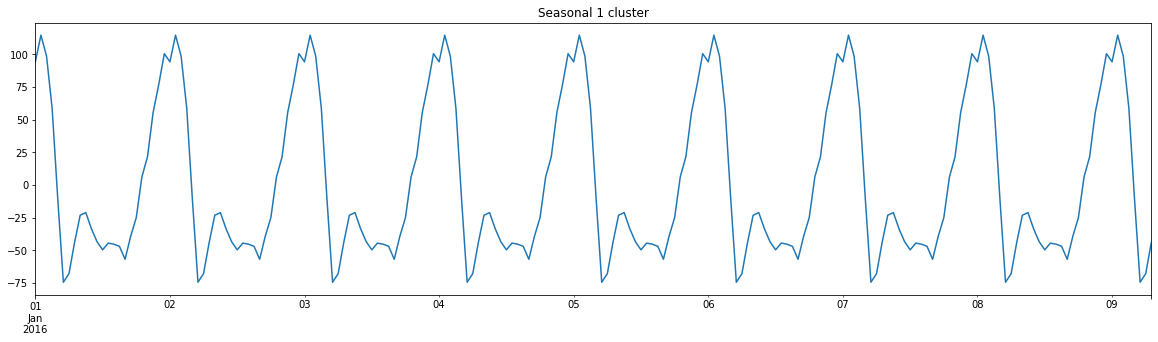

In [266]:
sm.tsa.seasonal_decompose(train_data['resid_y1'][:200]).seasonal.plot(figsize=(20,5), title = 'Seasonal 1 cluster')

<AxesSubplot:title={'center':'Seasonal 2 cluster'}>

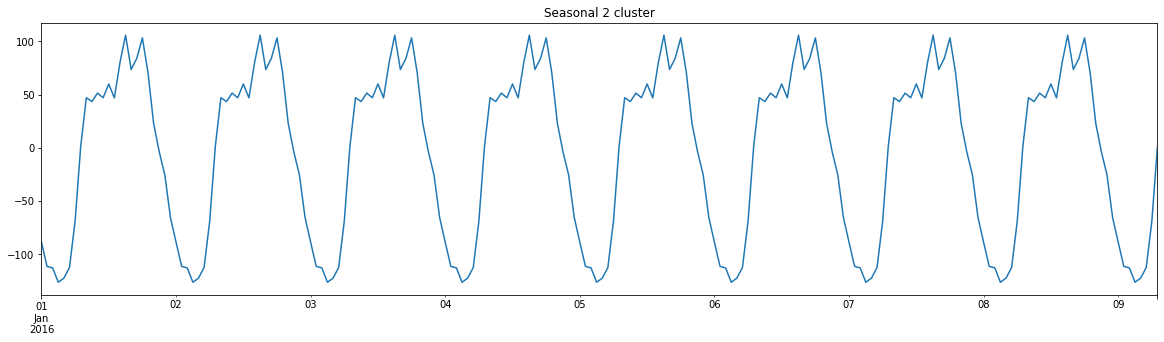

In [267]:
sm.tsa.seasonal_decompose(train_data['resid_y2'][:200]).seasonal.plot(figsize=(20,5), title = 'Seasonal 2 cluster')

<AxesSubplot:title={'center':'Seasonal 3 cluster'}>

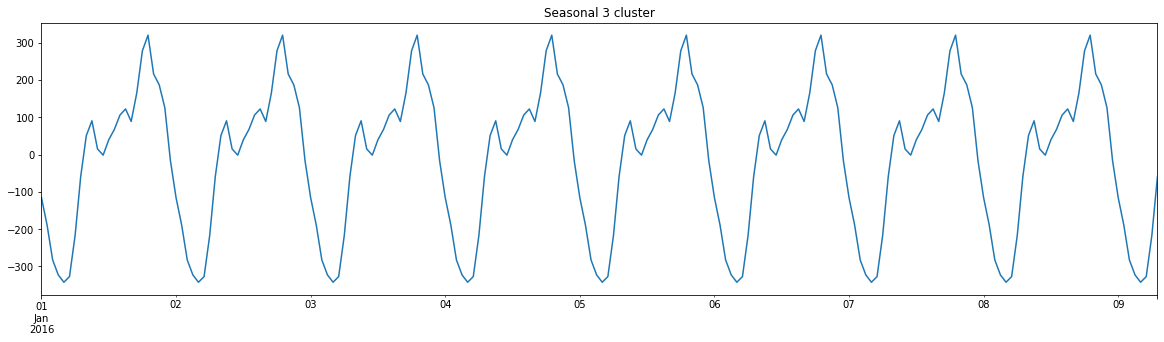

In [268]:
sm.tsa.seasonal_decompose(train_data['resid_y3'][:200]).seasonal.plot(figsize=(20,5), title = 'Seasonal 3 cluster')

### Ярко-выраженная дневная сезонность у всех кластеров

<AxesSubplot:title={'center':'Trend 1 cluster'}>

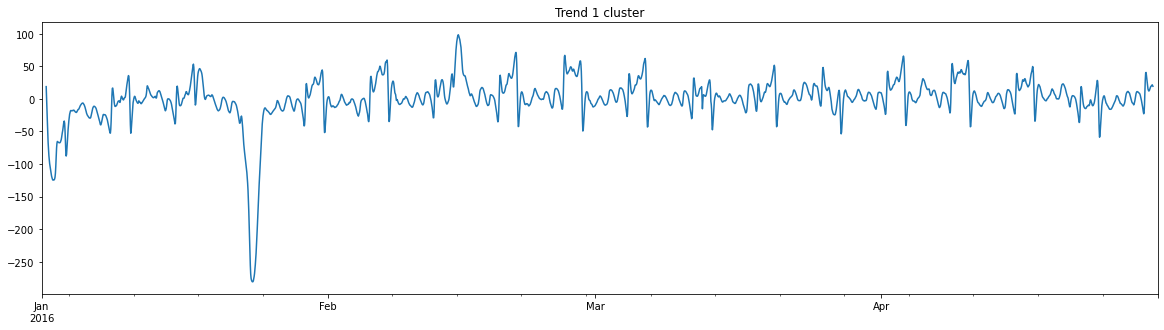

In [269]:
sm.tsa.seasonal_decompose(train_data['resid_y1']).trend.plot(figsize=(20,5), title='Trend 1 cluster')

<AxesSubplot:title={'center':'Trend 2 cluster'}>

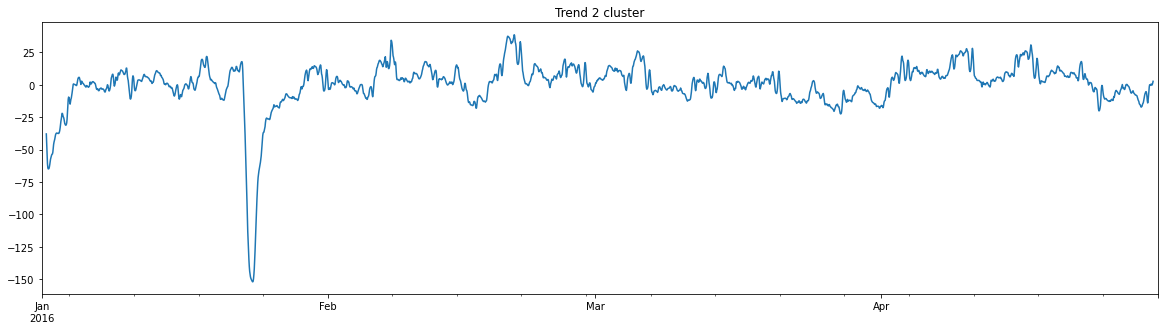

In [270]:
sm.tsa.seasonal_decompose(train_data['resid_y2']).trend.plot(figsize=(20,5), title='Trend 2 cluster')

<AxesSubplot:title={'center':'Trend 3 cluster'}>

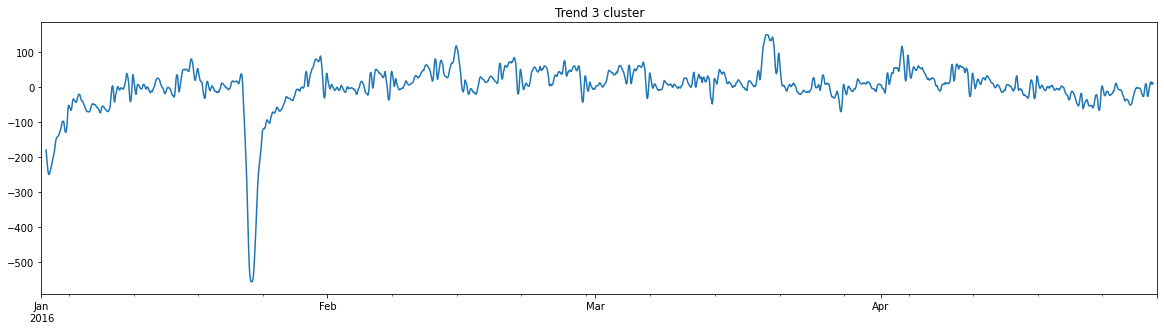

In [271]:
sm.tsa.seasonal_decompose(train_data['resid_y3']).trend.plot(figsize=(20,5), title='Trend 3 cluster')

### Тренд отсутствует, но есть аномалии

<AxesSubplot:title={'center':'Residuals 1 cluster'}>

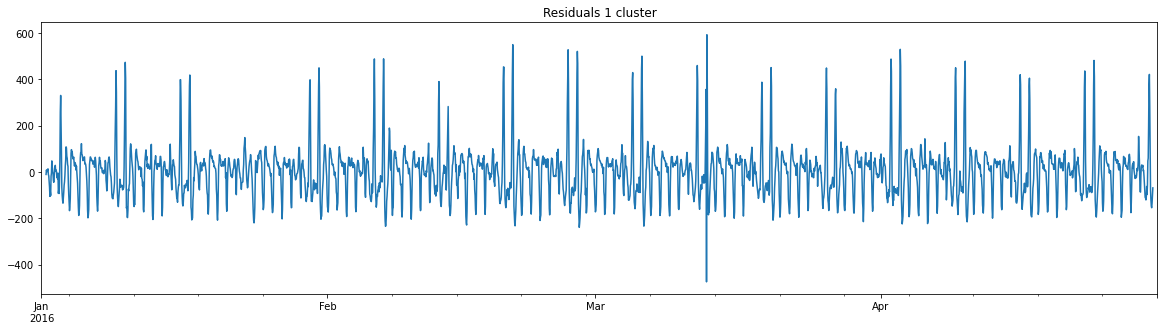

In [272]:
sm.tsa.seasonal_decompose(train_data['resid_y1']).resid.plot(figsize=(20,5), title='Residuals 1 cluster')

<AxesSubplot:title={'center':'Residuals 2 cluster'}>

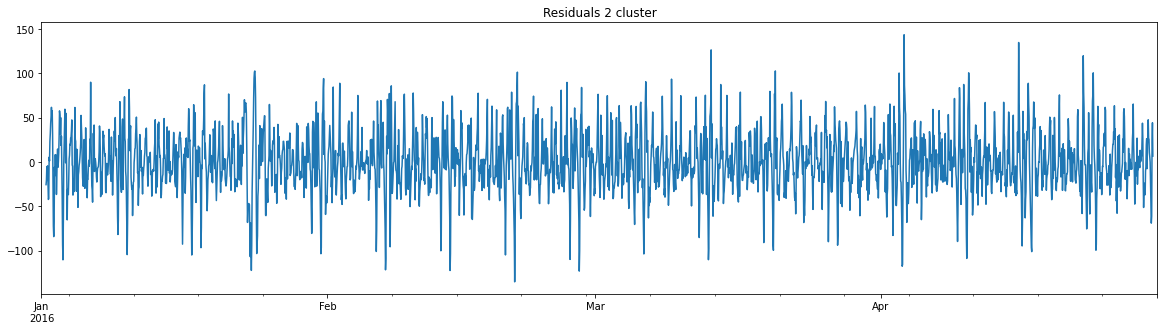

In [273]:
sm.tsa.seasonal_decompose(train_data['resid_y2']).resid.plot(figsize=(20,5), title='Residuals 2 cluster')

<AxesSubplot:title={'center':'Residuals 3 cluster'}>

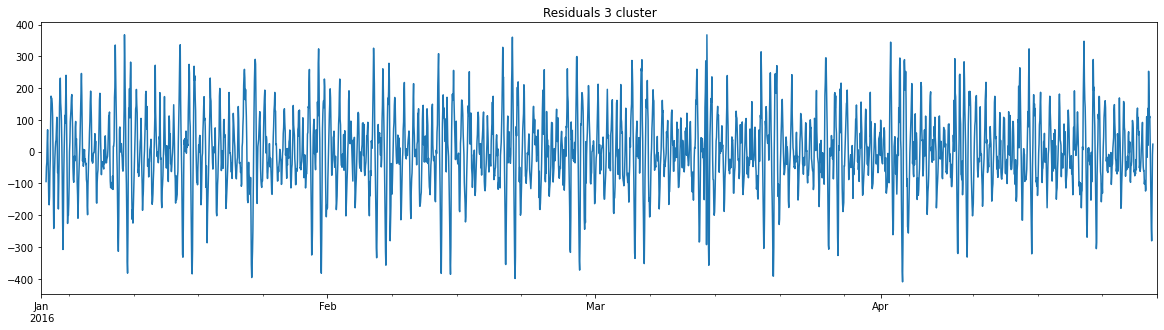

In [274]:
sm.tsa.seasonal_decompose(train_data['resid_y3']).resid.plot(figsize=(20,5), title='Residuals 3 cluster')

### Остатки не смещены

## 3) Проведем дневное дифференцирование всех рядов

<AxesSubplot:title={'center':'Residuals 1'}>

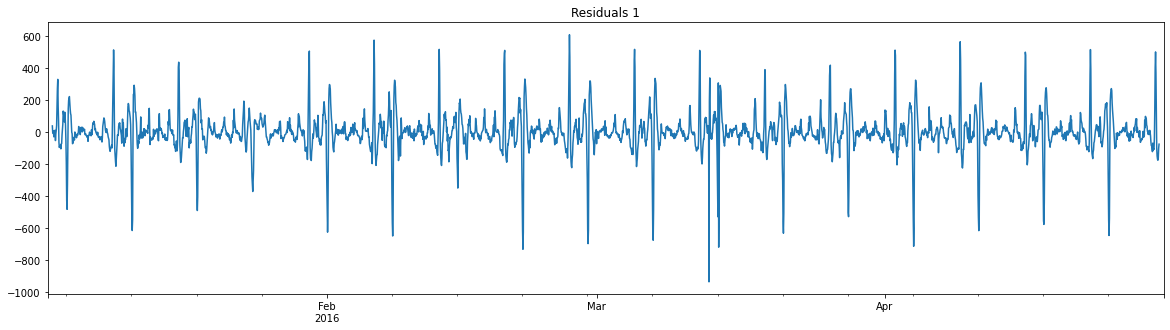

In [275]:
sm.tsa.seasonal_decompose(train_data['resid_y1'].diff(24)[24:]).resid.plot(figsize=(20,5), title='Residuals 1')

In [276]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['resid_y1'].diff(24)[24:])[1])

Критерий Дики-Фуллера: p=0.000000


<AxesSubplot:title={'center':'Residuals 2'}>

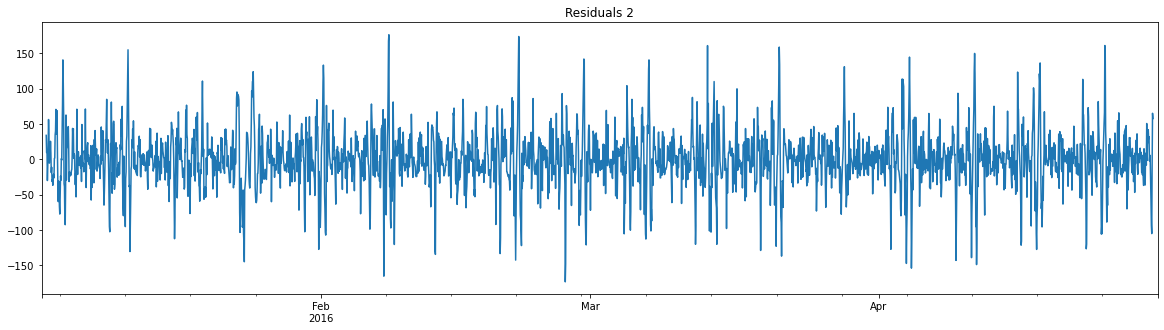

In [277]:
sm.tsa.seasonal_decompose(train_data['resid_y2'].diff(24)[24:]).resid.plot(figsize=(20,5), title='Residuals 2')

In [278]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['resid_y2'].diff(24)[24:])[1])

Критерий Дики-Фуллера: p=0.000000


<AxesSubplot:title={'center':'Residuals 3'}>

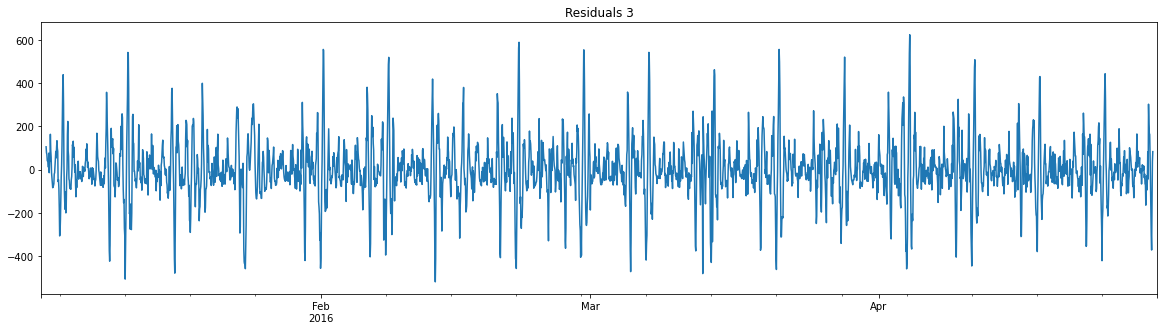

In [279]:
sm.tsa.seasonal_decompose(train_data['resid_y3'].diff(24)[24:]).resid.plot(figsize=(20,5), title='Residuals 3')

In [280]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['resid_y3'].diff(24)[24:])[1])

Критерий Дики-Фуллера: p=0.000000


### Картина стала существенно лучше. Двигаемся дальше

## 4.1) Оценим p,P, q,Q

### 1 модель

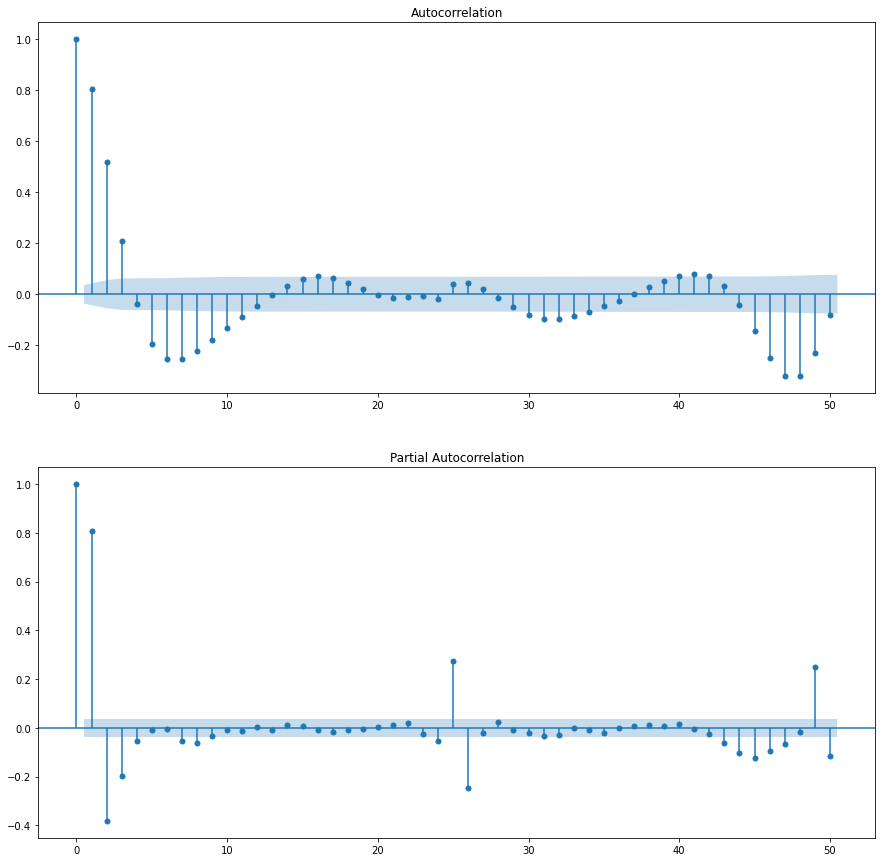

In [281]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sm.graphics.tsa.plot_acf(train_data['resid_y1'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['resid_y1'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[1])
plt.show()

### Начальное приближение

Q=0, q=3, P=1, p=4

#Сезонность - 24 часа

In [292]:
ps = range(2, 5)
d=0
qs = range(2, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [293]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

## 5.1) Подберем параметры модели

In [294]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['y1'],
                                        exog=train_data[['w_s1', 'w_c1', 'w_s2', 'w_c2', 'w_s3', 'w_c3', 'w_s4', 'w_c4',
       'w_s5', 'w_c5']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

CPU times: user 21min 15s, sys: 33min 3s, total: 54min 18s
Wall time: 15min 33s


/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [295]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     parameters           aic
3  (2, 3, 1, 0)  32241.110820
1  (2, 2, 1, 0)  32243.726218
5  (3, 2, 1, 0)  32245.104555
9  (4, 2, 1, 0)  32247.126689
7  (3, 3, 1, 0)  32247.305978


In [296]:
print(best_model_1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                  y1   No. Observations:                 2904
Model:             SARIMAX(2, 0, 3)x(1, 1, [], 24)   Log Likelihood              -16103.555
Date:                             Tue, 13 Apr 2021   AIC                          32241.111
Time:                                     22:25:59   BIC                          32342.525
Sample:                                 01-01-2016   HQIC                         32277.665
                                      - 04-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w_s1          86.7951      7.918     10.962      0.000      71.277     102.313
w_c1          24.8917      

/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


## 6.1) Анализ остатков

Критерий Стьюдента: p=0.961118
Критерий Дики-Фуллера: p=0.000000


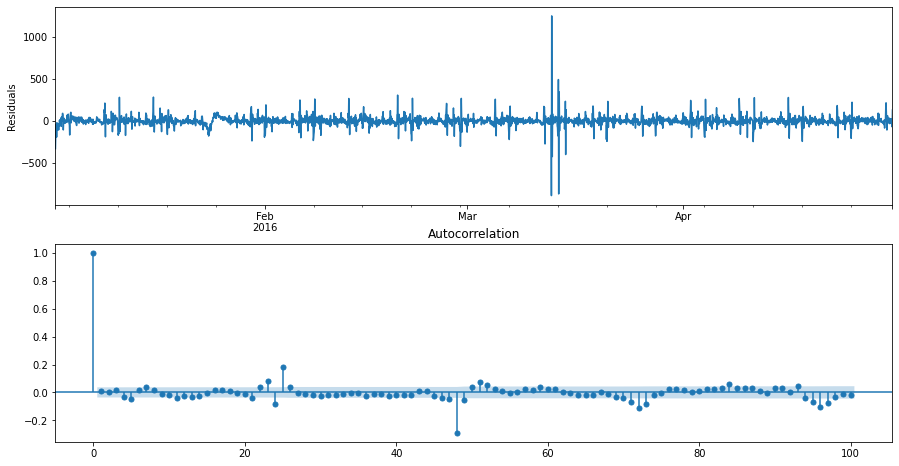

In [310]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model_1.resid[24:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_1.resid[24:].values.squeeze(), lags=100, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_1.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_1.resid[24:])[1])

#### Если судить по критерию Льюнга-Бокса остатки являются независимыми (отсутствует автокорреляция). Посмотрим также на их распределение и Q-Q plot:

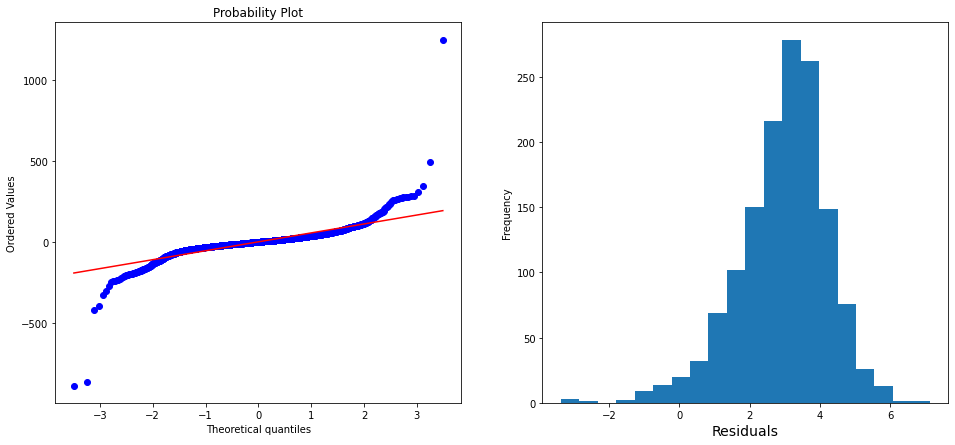

In [306]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(best_model_1.resid[24:], dist="norm", plot=plt)
plt.subplot(122)
np.log(best_model_1.resid[24:]).plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
plt.show()

### 7.1) Проверка предсказаний

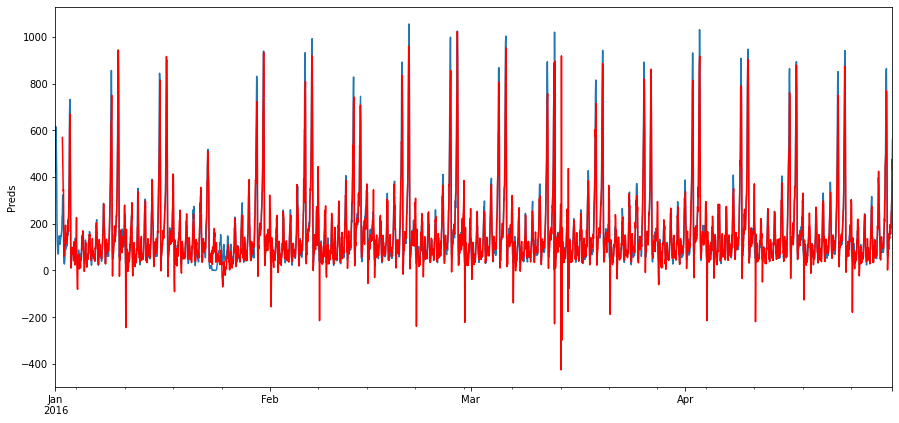

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [299]:
train_data['model_1'] = best_model_1.fittedvalues
plt.figure(figsize=(15,7))
train_data.y1.plot()
train_data.model_1[24:].plot(color='r')
plt.ylabel('Preds')
plt.show()

#### Очень хорошо. Переходим к обучению 2 модели

### 2 модель

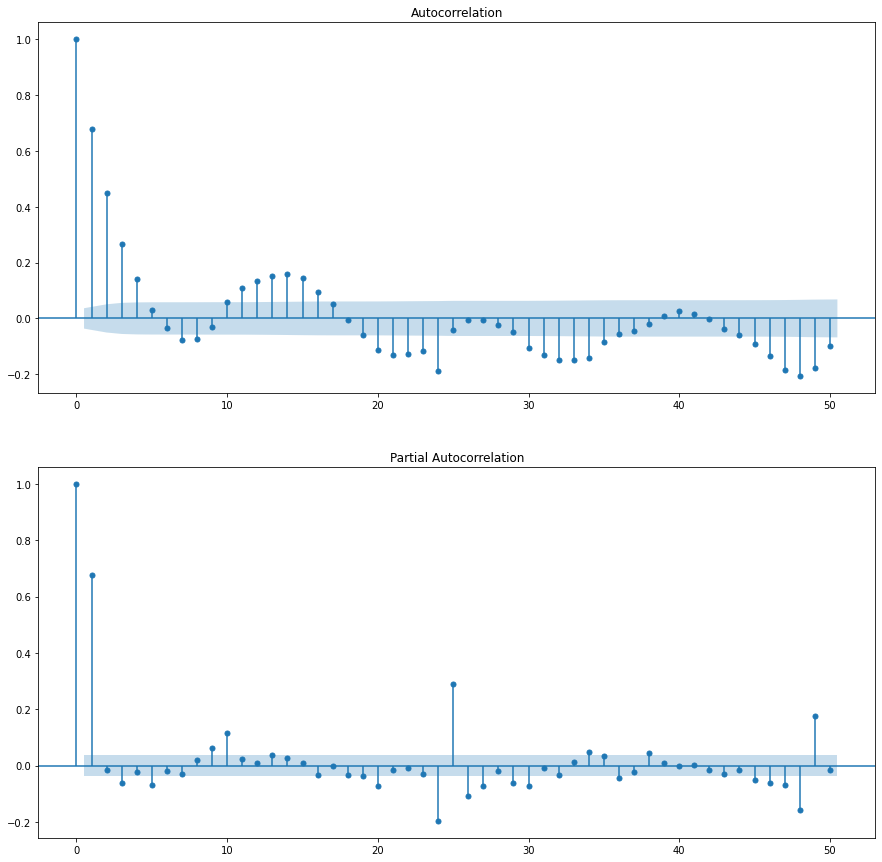

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [300]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sm.graphics.tsa.plot_acf(train_data['resid_y2'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['resid_y2'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[1])
plt.show()

### Начальное приближение

Q=2, q=4, P=2, p=1

#Сезонность - 24 часа

In [303]:
ps = range(1, 2)
d=0
qs = range(2, 5)
Ps = range(1, 3)
D=1
Qs = range(1, 3)

In [304]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

## 5.2) Подберем параметры модели

In [315]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['y2'],
                                        exog=train_data[['w_s1', 'w_c1', 'w_s2', 'w_c2', 'w_s3', 'w_c3', 'w_s4', 'w_c4',
       'w_s5', 'w_c5']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

CPU times: user 2h 29min 47s, sys: 2h 27min 39s, total: 4h 57min 26s
Wall time: 1h 16min 27s


/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [316]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      parameters           aic
10  (1, 4, 2, 1)  26885.735617
2   (1, 2, 2, 1)  26891.943464
6   (1, 3, 2, 1)  26892.998652
9   (1, 4, 1, 2)  26893.579313
1   (1, 2, 1, 2)  26899.327949


In [317]:
print(best_model_2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                   y2   No. Observations:                 2904
Model:             SARIMAX(1, 0, 4)x(2, 1, [1], 24)   Log Likelihood              -13423.868
Date:                              Wed, 14 Apr 2021   AIC                          26885.736
Time:                                      08:07:19   BIC                          26999.081
Sample:                                  01-01-2016   HQIC                         26926.590
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w_s1           4.3741      2.611      1.675      0.094      -0.743       9.492
w_c1          11.21

/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


## 6.2) Анализ остатков

Критерий Стьюдента: p=0.011251
Критерий Дики-Фуллера: p=0.000000


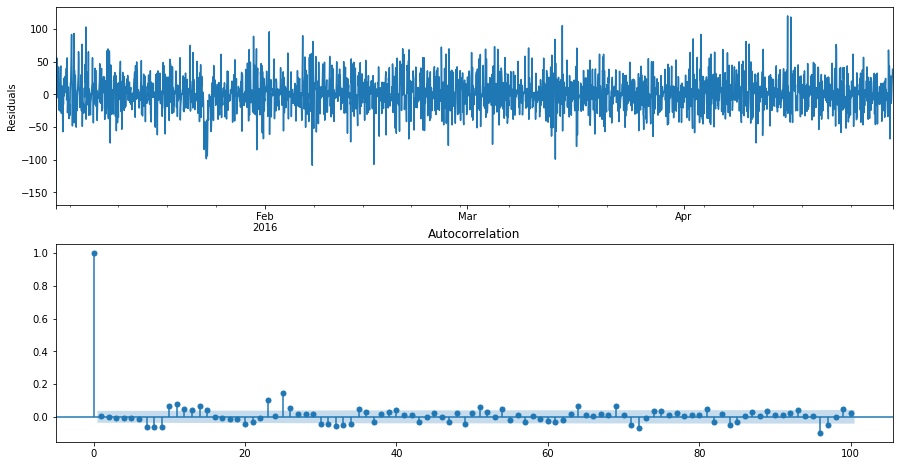

/kernel/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [318]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model_2.resid[24:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_2.resid[24:].values.squeeze(), lags=100, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_2.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_2.resid[24:])[1])

##### На значение критерия стьюдента повлиял выброс

#### Если судить по критерию Льюнга-Бокса остатки являются независимыми (отсутствует автокорреляция). Посмотрим также на их распределение и Q-Q plot:

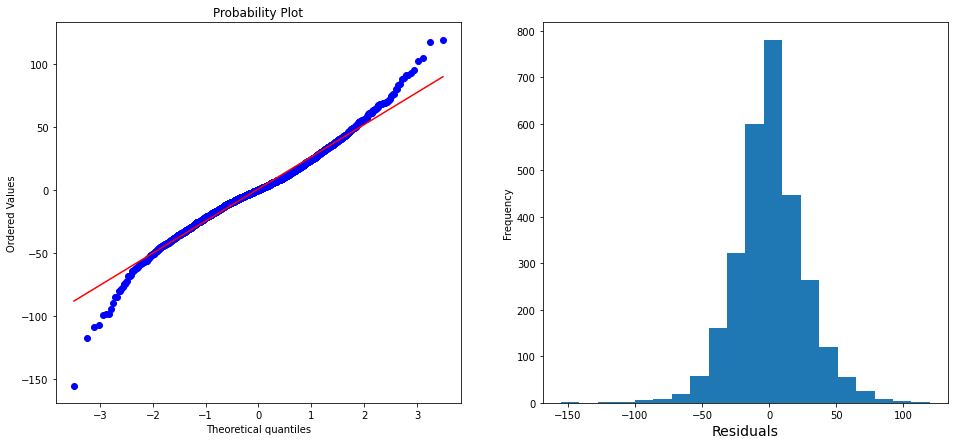

In [320]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(best_model_2.resid[24:], dist="norm", plot=plt)
plt.subplot(122)
best_model_2.resid[24:].plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
plt.show()

## 7.2) Проверка предсказаний

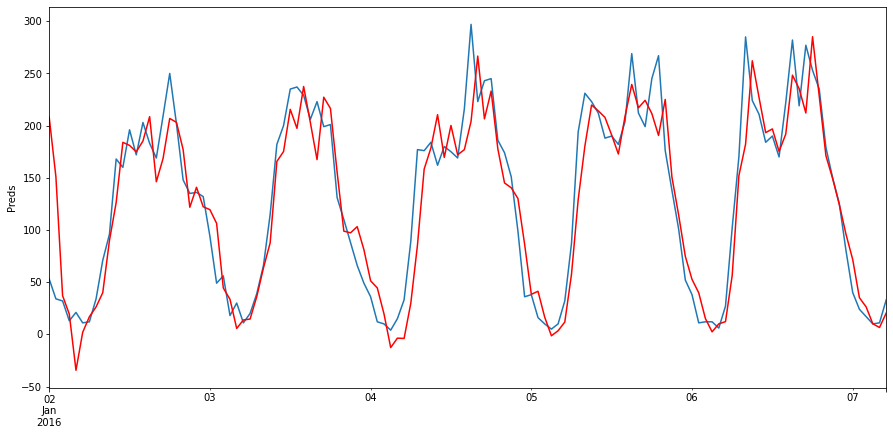

In [322]:
train_data['model_2'] = best_model_2.fittedvalues
plt.figure(figsize=(15,7))
train_data.y2[24:150].plot()
train_data.model_2[24:150].plot(color='r')
plt.ylabel('Preds')
plt.show()

## 3 модель

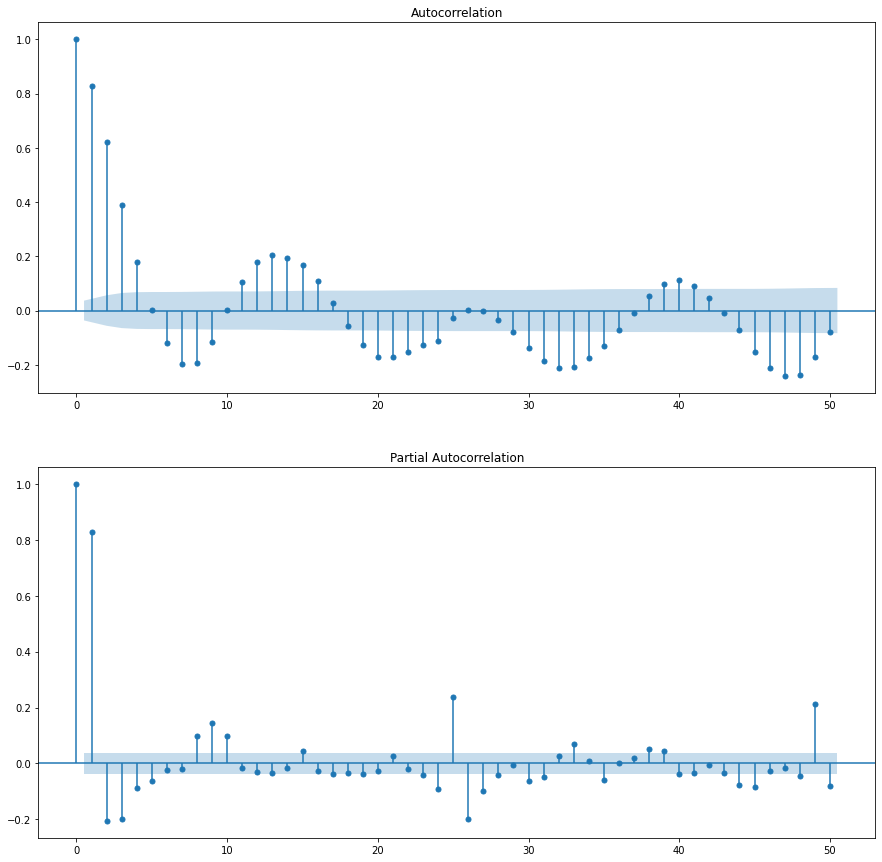

In [323]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sm.graphics.tsa.plot_acf(train_data['resid_y3'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['resid_y3'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[1])
plt.show()

### Начальное приближение

Q=2, q=4, P=1, p=5

#Сезонность - 24 часа

In [331]:
ps = range(4, 6)
d=0
qs = range(3, 5)
Ps = range(1, 2)
D=1
Qs = range(1, 3)

In [332]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

## 5.3) Подберем параметры модели

In [333]:
#!c1.8
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['y3'],
                                        exog=train_data[['w_s1', 'w_c1', 'w_s2', 'w_c2', 'w_s3', 'w_c3', 'w_s4', 'w_c4',
       'w_s5', 'w_c5']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

CPU times: user 3h 30min 30s, sys: 3h 36min 29s, total: 7h 7min
Wall time: 1h 53min 46s
CPU times: user 2h 2min 16s, sys: 3h 14min 33s, total: 5h 16min 50s
Wall time: 56min 10s


/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)
/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:66: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [336]:
#!c1.8
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
1  (4, 3, 1, 2)  31989.751779
4  (5, 3, 1, 1)  32015.201086
6  (5, 4, 1, 1)  32019.364917
2  (4, 4, 1, 1)  32027.026869
0  (4, 3, 1, 1)  32051.742660


In [337]:
#!c1.8
print(best_model_3.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      y3   No. Observations:                 2904
Model:             SARIMAX(4, 0, 3)x(1, 1, [1, 2], 24)   Log Likelihood              -15973.876
Date:                                 Wed, 14 Apr 2021   AIC                          31989.752
Time:                                         12:06:22   BIC                          32115.028
Sample:                                     01-01-2016   HQIC                         32034.907
                                          - 04-30-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w_s1          28.0699     10.884      2.579      0.010       6.738      49

## 6.3) Анализ остатков

Критерий Стьюдента: p=0.000968
Критерий Дики-Фуллера: p=0.000000


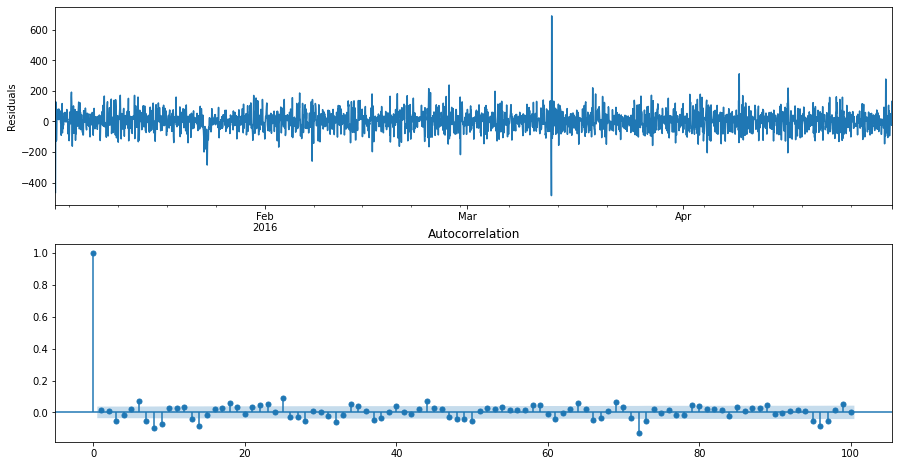

In [338]:
#!c1.8
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model_3.resid[24:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_3.resid[24:].values.squeeze(), lags=100, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_3.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_3.resid[24:])[1])

##### На значение критерия стьюдента повлиял выброс

#### Если судить по критерию Льюнга-Бокса остатки являются независимыми (отсутствует автокорреляция). Посмотрим также на их распределение и Q-Q plot:

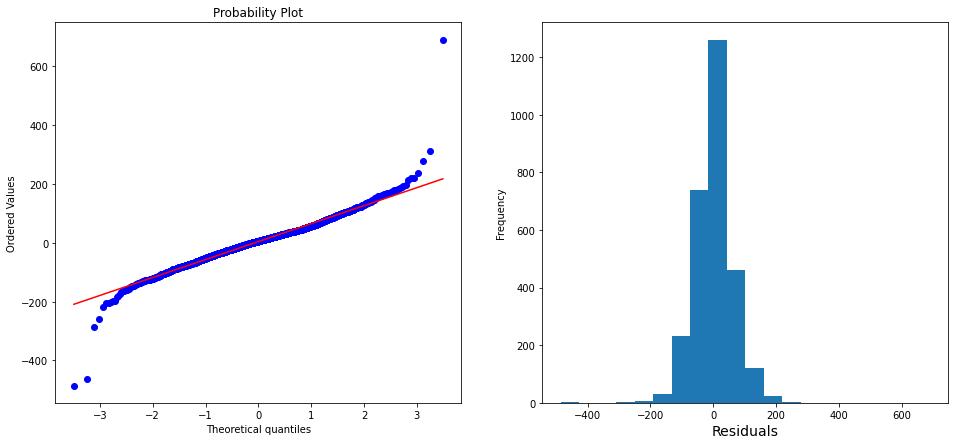

In [344]:
#!c1.8
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(best_model_3.resid[24:], dist="norm", plot=plt)
plt.subplot(122)
best_model_3.resid[24:].plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
plt.show()

## 7.3) Проверка предсказаний

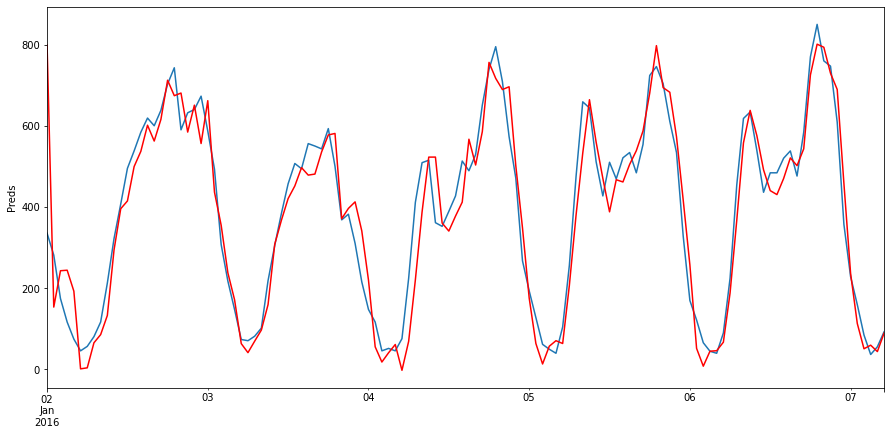

In [345]:
#!c1.8
train_data['model_3'] = best_model_3.fittedvalues
plt.figure(figsize=(15,7))
train_data.y3[24:150].plot()
train_data.model_3[24:150].plot(color='r')
plt.ylabel('Preds')
plt.show()

## Построение предсказаний на май

In [432]:
#!c1.8
data.index=pd.DatetimeIndex(data.index, freq=data.index.inferred_freq)

In [348]:
#!c1.8
for i in range(1, 6):
    data[f'w_s{i}']=np.sin(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)
    data[f'w_c{i}']=np.cos(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)

In [466]:
#!c1.8
answers_may=pd.Series()
true_vals=pd.Series()

In [355]:
#!c1.8
models=[best_model_1, best_model_2, best_model_3]

In [356]:
#!c1.8
exog=data[['w_s1', 'w_c1', 'w_s2', 'w_c2', 'w_s3', 'w_c3', 'w_s4', 'w_c4',
       'w_s5', 'w_c5']]

In [357]:
#!c1.8
orders=[(2, 0, 3), (1, 0, 4), (4, 0, 3)]
seasonal_orders=[(1,1,0,24), (2,1,1,24), (1,1,2,24)]

### Одновременно создаем 2 серии. Первая будет записывать предсказания, а вторая в том же формате реальные значения. Потом будет проще посчитать метрику.

In [ ]:
#%%time
#for r in data.columns:
#    fitted_model=models[w[f'{r}']-1]
#    mod=sm.tsa.statespace.SARIMAX(data[f'{r}'],
#                                        exog=exog,
#                                        order=orders[w[f'{r}']-1], 
#                                        seasonal_order=seasonal_orders[w[f'{r}']-1],
#                                     freq='1h').filter(fitted_model.params)
#    for i in pd.date_range('2016-04-30 23:00', '2016-05-31 17:00', freq='H'):
#        
#        ind=[i.strftime(f'{r}_%F_%H_{p}') for p in range(1,7)]
#    
#        tt=pd.Series(data=mod.predict(i+pd.Timedelta('1h'),
#                                      i+pd.Timedelta('6h'), dynamic=True,
#                                      exog=exog.loc[i+pd.Timedelta('1h'): i+pd.Timedelta('6h')]).values,
#                     index=ind)
#        tr=pd.Series(data=data[f'{r}'].loc[i+pd.Timedelta('1h'): i+pd.Timedelta('6h')].values,
#                     index=ind)
#        answers_may=answers_may.append(tt)
#        true_vals=true_vals.append(tr)

#### Вылезало много ошибок, поэтому закомментировал

In [469]:
#!c1.8
answers_may

1075_2016-04-30_23_1     74.412108
1075_2016-04-30_23_2     53.652387
1075_2016-04-30_23_3     36.945158
1075_2016-04-30_23_4     26.323280
1075_2016-04-30_23_5     23.335506
                           ...    
2168_2016-05-31_17_2    125.367249
2168_2016-05-31_17_3    141.211891
2168_2016-05-31_17_4    145.458244
2168_2016-05-31_17_5    150.930401
2168_2016-05-31_17_6    118.694595
Length: 452268, dtype: float64

In [470]:
#!c1.8
true_vals

1075_2016-04-30_23_1     71
1075_2016-04-30_23_2     37
1075_2016-04-30_23_3     10
1075_2016-04-30_23_4     14
1075_2016-04-30_23_5      6
                       ... 
2168_2016-05-31_17_2    103
2168_2016-05-31_17_3    111
2168_2016-05-31_17_4    130
2168_2016-05-31_17_5    123
2168_2016-05-31_17_6    132
Length: 452268, dtype: int64

In [478]:
#!c1.8
Q=1/(102*739*6)*(np.abs(answers_may-true_vals).sum())
print(Q)

59.815751548729516


## Построение предсказаний на июнь

In [481]:
#!c1.8
answers_june=pd.Series()
true_vals_june=pd.Series()

In [ ]:
#%%time
#for r in data.columns:
#    fitted_model=models[w[f'{r}']-1]
#    mod=sm.tsa.statespace.SARIMAX(data[f'{r}'],
#                                        exog=exog,
#                                        order=orders[w[f'{r}']-1], 
#                                        seasonal_order=seasonal_orders[w[f'{r}']-1],
#                                     freq='1h').filter(fitted_model.params)
#    for i in pd.date_range('2016-05-31 23:00', '2016-06-30 17:00', freq='H'):
#        
#        ind=[i.strftime(f'{r}_%F_%H_{p}') for p in range(1,7)]
#    
#        tt=pd.Series(data=mod.predict(i+pd.Timedelta('1h'),
#                                      i+pd.Timedelta('6h'), dynamic=True,
#                                      exog=exog.loc[i+pd.Timedelta('1h'): i+pd.Timedelta('6h')]).values,
#                     index=ind)
#        tr=pd.Series(data=data[f'{r}'].loc[i+pd.Timedelta('1h'): i+pd.Timedelta('6h')].values,
#                     index=ind)
#        answers_june=answers_june.append(tt)
#        true_vals_june=true_vals_june.append(tr)

#### Вылезало много ошибок, поэтому закомментировал

In [483]:
#!c1.8
answers_june

1075_2016-05-31_23_1    19.724584
1075_2016-05-31_23_2    10.159134
1075_2016-05-31_23_3     4.303869
1075_2016-05-31_23_4     0.515531
1075_2016-05-31_23_5     1.856931
                          ...    
2168_2016-06-30_17_2    32.078226
2168_2016-06-30_17_3    47.971771
2168_2016-06-30_17_4    58.751636
2168_2016-06-30_17_5    69.756048
2168_2016-06-30_17_6    50.988964
Length: 437580, dtype: float64

In [484]:
#!c1.8
true_vals_june

1075_2016-05-31_23_1    26
1075_2016-05-31_23_2    14
1075_2016-05-31_23_3     5
1075_2016-05-31_23_4     2
1075_2016-05-31_23_5     1
                        ..
2168_2016-06-30_17_2     1
2168_2016-06-30_17_3     0
2168_2016-06-30_17_4     1
2168_2016-06-30_17_5     0
2168_2016-06-30_17_6     0
Length: 437580, dtype: int64

In [485]:
#!c1.8
Q_j=1/(102*715*6)*(np.abs(answers_june-true_vals_june).sum())
print(Q_j)

55.79854158886492


### Проверим зрительно

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


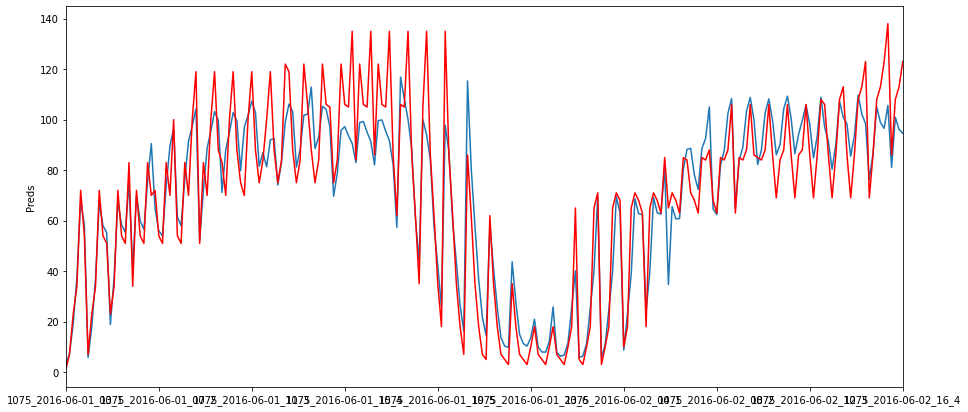

In [488]:
#!c1.8
plt.figure(figsize=(15,7))
answers_june.iloc[24:250].plot()
true_vals_june.iloc[24:250].plot(color='r')
plt.ylabel('Preds')
plt.show()

## Неплохо!

## Запись решения в файл

In [490]:
#!c1.8
answers_june.shape[0]

437580

In [492]:
#!c1.8
answers_june.name='y'

### Перейдем с помощью регулярки к нужному формату

In [513]:
#!c1.8
answers_june.index=answers_june.index.str.replace(r'_0', '_')

In [514]:
answers_june.index

Index(['1075_2016-05-31_23_1', '1075_2016-05-31_23_2', '1075_2016-05-31_23_3',
       '1075_2016-05-31_23_4', '1075_2016-05-31_23_5', '1075_2016-05-31_23_6',
       '1075_2016-06-01_0_1', '1075_2016-06-01_0_2', '1075_2016-06-01_0_3',
       '1075_2016-06-01_0_4',
       ...
       '2168_2016-06-30_16_3', '2168_2016-06-30_16_4', '2168_2016-06-30_16_5',
       '2168_2016-06-30_16_6', '2168_2016-06-30_17_1', '2168_2016-06-30_17_2',
       '2168_2016-06-30_17_3', '2168_2016-06-30_17_4', '2168_2016-06-30_17_5',
       '2168_2016-06-30_17_6'],
      dtype='object', length=437580)

In [515]:
#!c1.8
answers_june.to_csv('sample_solution.csv', index_label='id', header=True)

## Cсылка на submission

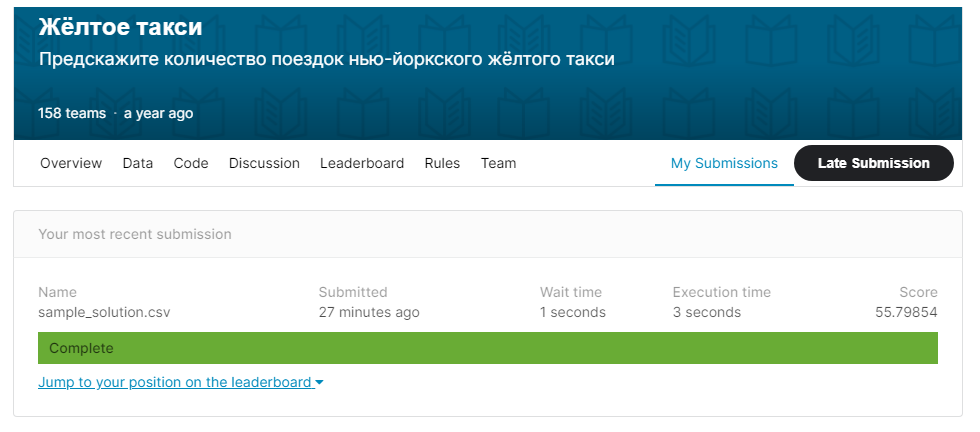